## Import Libaries

In [ ]:
from datasets import load_dataset
from tokenizers import Tokenizer
from transformers import AutoTokenizer, PreTrainedTokenizerFast,AutoModelForCausalLM, AutoModelForSeq2SeqLM
from collections import Counter
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import sentencepiece as spm
from collections import defaultdict
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.core_functions import *
import seaborn as sns
import re
import ast
import unicodedata
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from IPython.display import display, HTML
access_token = "access_token"

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version 

## Load Existing Model Tokenizers 

In [2]:
gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it", trust_remote_code=True, token=access_token)
gemma_vocab = list(gemma_tokenizer.vocab)
gemma_tokenizer.save_pretrained('./tokenizers/gemma')
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_vocab = list(bert_tokenizer.vocab)
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
xlmr_vocab = list(xlmr_tokenizer.vocab)
mt5_tokenizer = AutoTokenizer.from_pretrained("google/mt5-base")
mt5_vocab = list(mt5_tokenizer.vocab)
mbart_tokenizer = tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
mbart_vocab = list(mbart_tokenizer.vocab.keys())
indic_bert = AutoTokenizer.from_pretrained("ai4bharat/indic-bert",use_auth_token=access_token)
indic_bert_vocab = list(indic_bert.vocab.keys())
print(len(gemma_vocab), len(bert_vocab), len(xlmr_vocab), len(mt5_vocab), len(mbart_vocab), len(indic_bert_vocab))

/opt/conda/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:935: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


262145 119547 250002 250100 250054 200000


## Load Datasets

In [3]:
ds = load_dataset("gsarti/flores_101", "all")
Flores_df = pd.concat([ds[split].to_pandas() for split in ds], ignore_index=True)
Flores_Tamil_df = Flores_df[['sentence_tam']].copy()
Flores_Tamil_df.columns = ['sentence']

flores_df = Flores_df.rename(columns={'sentence_tam' : 'context'})
unique_df = df_extract_unique_words(Flores_df)
unique_df = unique_df.rename(columns={0:"Words"})
unique_df['Words'] = unique_df['Words'].str.lstrip()

morphscore_ds = load_dataset("catherinearnett/morphscore")
morphScore_df = morphscore_ds['train'].to_pandas()
languages = ['tam_taml', 'tur_latn', 'spa_latn','eng_latn', 'arb_latn','deu_latn','fra_latn','fin_latn','nld_latn']
features_to_select = ['wordform', 'stem', 'following_part']

dfs = {}
for lang in languages:
    dfs[lang] = morphScore_df[morphScore_df['language'] == lang][features_to_select]
    
Morph_data_Tamil = dfs['tam_taml']

## Function Definitions

In [4]:
Tamil_Dependent_Vowels = ['\u0BBE', '\u0BBF', '\u0BC0', '\u0BC1', '\u0BC2', '\u0BC6', '\u0BC7', '\u0BC8', '\u0BCA', '\u0BCB', '\u0BCC', '\u0BD7']
Script_Ranges = {"Tamil": [('\u0B80', '\u0BFF')]}

tokenizers = {
    "mBERT": bert_tokenizer,
    "XLM-R": xlmr_tokenizer,
    "mT5": mt5_tokenizer,
    "Gemma": gemma_tokenizer,
    "mBART": mbart_tokenizer,
    "IndicBERT": indic_bert
}
vocabs = {
    "mBERT": 707,
    "XLM-R": 2605,
    "mT5": 3306,
    "Gemma": 3821,
    "mBART": 2605,
    "IndicBERT": 21716
}

def normalize_vocab(vocab):
    return [unicodedata.normalize('NFC', token) for token in vocab]

def is_tamil_dependent_vowel(ch):
    return ch in Tamil_Dependent_Vowels

def starts_with_vowel_sign(token):
    for ch in token:
        if unicodedata.name(ch, "").startswith("TAMIL"):
            return is_tamil_dependent_vowel(ch)
    return False

def percent_vowel_start(vocab, tokenizer_name):
    vocab = normalize_vocab(vocab)
    total = tokenizer_script_counts[tokenizer_name]['Tamil']
    if total == 0:
        return 0.0
    count = sum(1 for token in vocab if (len(token) == 1) and (0x0B80 <= ord(token) <= 0x0BFF))
    return (count / total) * 100

def decodeBytes(token: str) -> str:
    try:
        decoded_bytes = bytes(token, "latin-1")
        decoded = decoded_bytes.decode("utf-8", errors="replace")
        return decoded
    except Exception:
        return token

def guess_script(character: str) -> str:
    for script, ranges in Script_Ranges.items():
        for start, end in ranges:
            if start <= character <= end:
                return script
    return "Other"

def identify_script(token: str) -> str:
    decoded = decodeBytes(token)
    script_counter = {}
    for char in decoded:
        script = guess_script(char)
        script_counter[script] = script_counter.get(script, 0) + 1
    if not script_counter:
        return "Other"
    return max(script_counter, key=script_counter.get)

def find_script_capacity(vocab: list, tokenizer: str):
    script_counts = {script: 0 for script in Script_Ranges}
    script_counts["Other"] = 0
    for token in vocab:
        script = identify_script(token)
        if script in script_counts:
            script_counts[script] += 1
        else:
            script_counts["Other"] += 1
    total_tokens = len(vocab)
    return script_counts

def safe_tokenize_with_hf(tokenizer, text):
    try:
        toks = tokenizer.tokenize(str(text))
        return toks
    except Exception:
        try:
            enc = tokenizer.encode(str(text), add_special_tokens=False)
            if hasattr(enc, 'tokens'):
                return enc.tokens
            if isinstance(enc, (list, tuple)):
                return [tokenizer.convert_ids_to_tokens(i) for i in enc]
        except Exception:
            return [str(text)] 

In [5]:
tokenizer_script_counts = {}
tokenizer_script_counts['mBert Tokenizer'] = find_script_capacity(bert_vocab,"Bert")
tokenizer_script_counts['XLM-R Tokenizer'] = find_script_capacity(xlmr_vocab, "XLM-R")
tokenizer_script_counts['mt-5 Tokenizer'] = find_script_capacity(mt5_vocab,"Mt-5")
tokenizer_script_counts['Gemma Tokenizer'] = find_script_capacity(gemma_vocab,"Gemma")
tokenizer_script_counts['mBART Tokenizer'] = find_script_capacity(mbart_vocab, "mBART")
tokenizer_script_counts['IndicBert Tokenizer'] = find_script_capacity(indic_bert_vocab, "Indic BERT")

In [ ]:
tokenizer_cols = ['Gemma', 'mBERT', 'XLMR', 'mBART', 'mT5']

def analyze_sentence_level(df, tokenizers, sentence_col='sentence'):
    df = df.copy()
    for name, tok in tokenizers.items():
        prefix = name
        token_col = f"{prefix}_tokens"
        char_count_col = f"{prefix}_char_count"
        tok_per_sent_col = f"{prefix}_tokens_per_sentence"
        compression_col = f"{prefix}_compression_ratio"
        fertility_col = f"{prefix}_fertility"

        tokens_list = []
        token_count = []
        char_count = []
        word_count = []

        for sent in df[sentence_col]:
            tokens = remove_bert_characters(remove_sentencepiece_underscore(tok.tokenize(sent)))
            tokens_list.append(tokens)
            token_count.append(len(tokens))
            char_count.append(len(sent))
            word_count.append(len(sent.split(' ')))

        df[token_col] = tokens_list
        df[char_count_col] = char_count
        df[tok_per_sent_col] = token_count
        df[compression_col] = [lc / tc if tc > 0 else np.nan for lc, tc in zip(word_count, token_count)]
        df[fertility_col] = [lc / tc if tc > 0 else np.nan for lc, tc in zip(token_count, word_count)]
    return df

def calculate_corpus_renyi_efficiency(all_tokens, vocab_size, alpha=2):
    from collections import Counter
    counts = Counter(all_tokens)
    total = sum(counts.values())
    probs = np.array([c / total for c in counts.values()], dtype=np.float32)
    if alpha == 1:
        entropy = -np.sum(probs * np.log(probs + 1e-20))
    else:
        entropy = 1 / (1 - alpha) * np.log(np.sum(probs ** alpha))

    max_entropy = np.log(vocab_size)
    efficiency = entropy / max_entropy
    return efficiency

def compute_corpus_renyi_per_tokenizer(df, tokenizers, vocabs, sentence_col='sentence', alpha=2):
    renyi_efficiencies = {}
    for name, tok in tokenizers.items():
        vocab = vocabs[name]
        vocab_size = vocab

        all_tokens = []
        for sent in df[sentence_col]:
            tokens = remove_bert_characters(remove_sentencepiece_underscore(tok.tokenize(sent)))
            all_tokens.extend(tokens)
            
        renyi_score = calculate_corpus_renyi_efficiency(all_tokens, vocab_size, alpha=alpha)
        renyi_efficiencies[name] = renyi_score

    return renyi_efficiencies

def plot_corpus_renyi(tamil_df, english_df, tamil_renyi, english_renyi, tokenizers):
    tokenizer_names = list(tokenizers.keys())
    x = np.arange(len(tokenizer_names))
    width = 0.45
    tamil_eff = [tamil_renyi.get(tok, np.nan) for tok in tokenizer_names]
    eng_eff = [english_renyi.get(tok, np.nan) for tok in tokenizer_names]

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, tamil_eff, width, label='Tamil', color='tab:blue')
    plt.bar(x + width/2, eng_eff, width, label='English', color='tab:orange')
    plt.xticks(x, tokenizer_names, rotation=45, ha='right', fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Rényi Efficiency", fontsize=16)
    plt.xlabel("Model tokenizer", fontsize=16) 
    plt.grid(axis='y')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('Renyi.jpg', dpi=1000, bbox_inches='tight')
    plt.show()

def plot_compression_fertility(tokenizers, tamil_results, english_results, metric):
    tokenizer_names = list(tokenizers.keys())   
    x = np.arange(len(tokenizer_names))
    width = 0.35 
    
    plt.figure(figsize=(8, 5))
    
    tamil_means = [tamil_results[f"{tok}_{metric}"].mean() for tok in tokenizer_names]
    eng_means   = [english_results[f"{tok}_{metric}"].mean() for tok in tokenizer_names]

    if metric=="compression_ratio": 
        plt.bar(x - width/2, tamil_means, width, label='Tamil', color='tab:blue')
        plt.bar(x + width/2, eng_means,   width, label='English', color='tab:orange')
    else:
        plt.plot(x, tamil_means, marker='o', label='Tamil', color='tab:blue')
        plt.plot(x, eng_means, marker='o', label='English', color='tab:orange')
    plt.xticks(x, tokenizer_names, rotation=45, ha='right', fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=16)
    plt.xlabel('Model tokenizer', fontsize=16)
    
    plt.grid(axis='y')
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{metric}.jpg', dpi=1000, bbox_inches='tight')
    plt.show()

def plot_tokenization_premium(tokenizers, tamil_results, english_results):
    tokenizer_names = list(tokenizers.keys())
    x = np.arange(len(tokenizer_names))

    parity_means = [
        np.mean([tamil / eng for tamil, eng in zip(
            tamil_results[f"{tokenizer}_tokens_per_sentence"],
            english_results[f"{tokenizer}_tokens_per_sentence"]
        ) if eng != 0])
        for tokenizer in tokenizer_names
    ]
    
    plt.figure(figsize=(8, 5))
    plt.bar(x, parity_means, width=0.35, color='tab:blue')
    plt.xticks(x, tokenizer_names, rotation=45, ha='right', fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Tokenization Premium', fontsize=16)
    plt.xlabel('Model tokenizer', fontsize=16)
    plt.grid(axis='y')
    plt.savefig('TokenizationPremium.jpg', dpi=1000, bbox_inches='tight')
    plt.show()

def remove_sentencepiece_underscore(tokens):
    return [token.replace('▁', '') if token.startswith('▁') else token for token in tokens]
def remove_bert_underscore(tokens):
    return [token.replace('##', '') if token.startswith('#') else token for token in tokens]
    
def tokenization_function(df, morpho_tok = False):
    for name, tokenizer in tokenizer_dict.items():
        if name != "Morpho" and name != "Normal":         
            df.loc[:, name] = df['wordform'].apply(lambda x: tokenizer.tokenize(str(x)))
            df.loc[:, name] = df[name].apply(remove_sentencepiece_underscore).apply(remove_bert_underscore)
    if morpho_tok:
        df.loc[:, "Morpho"] = df['wordform'].apply(lambda x: morpho_tokenizer.encode(str(x), out_type=str))
        df.loc[:, "Morpho"] = df["Morpho"].apply(remove_sentencepiece_underscore)
        df.loc[:, "Normal"] = df['wordform'].apply(lambda x: normal_tokenizer.encode(str(x), out_type=str))
        df.loc[:, "Normal"] = df["Morpho"].apply(remove_sentencepiece_underscore)

def apply_tokenizer_dict(df, tokenizers, word_column="wordform", is_wordpiece=False):
    if is_wordpiece:
        for label, tok in tokenizers.items():
            df[label] = df[word_column].apply(lambda w: tok.encode(w,add_special_tokens=False).tokens).apply(remove_bert_underscore)
    else:
        for label, tok in tokenizers.items():
            df[label] = df[word_column].apply(lambda w: tok.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)
            
def get_boundaries(segmentation):
    boundaries = set()
    pos = 0
    for token in segmentation[:-1]:
        pos += len(token)
        boundaries.add(pos)
    return boundaries
    
def creutz_linden_f1(gold_segmentation, tokenizer_segmentation):
    gold_boundaries = get_boundaries(gold_segmentation)
    token_boundaries = get_boundaries(tokenizer_segmentation)
    if len(tokenizer_segmentation) == 1:
        tp = 1
        fp = 0
        fn = 0
        tn = 0
    else:
        tp = len(gold_boundaries.intersection(token_boundaries))
        fp = len(token_boundaries - gold_boundaries)
        fn = len(gold_boundaries - token_boundaries)
        tn = 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    accuracy = (tp + tn / (tp + fn + tn + tp)) if (tp + fn) > 0 else 0.0 
    return precision, recall, f1, accuracy

def creutz_linden_f1(gold_segmentation, tokenizer_segmentation, single_suffixes):
    gold_boundaries = get_boundaries(gold_segmentation)
    token_boundaries = get_boundaries(tokenizer_segmentation)
    if len(tokenizer_segmentation) == 1:
        tp = 1
        fp = 0
        fn = 0
        tn = 0
    else:
        tp = len(gold_boundaries.intersection(token_boundaries))
        fp = len(token_boundaries - gold_boundaries)
        fn = len(gold_boundaries - token_boundaries)
        tn = 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    accuracy = (tp + tn / (tp + tn + fp + fn)) if (tp + fn) > 0 else 0.0 
    return precision, recall, f1, accuracy

def compute_morphological_alignment(df, tokenizer_columns):
    results = {tok: {'precision': [], 'recall': [], 'f1': [], 'accuracy': [], 'length':[], 'total': []} for tok in tokenizer_columns}
    for idx, row in df.iterrows():
        gold = [row['stem'], row['following_part']]
        single_suffixes = 0
        for tok in tokenizer_columns:
            tokens = row[tok]
            p, r, f1, acc = creutz_linden_f1(gold, tokens, single_suffixes)
            results[tok]['precision'].append(p)
            results[tok]['recall'].append(r)
            results[tok]['f1'].append(f1)
            results[tok]['accuracy'].append(acc)
            results[tok]['total'].append(1)
            results[tok]['length'].append(len(tokens))
    stats = {}
    for tok, vals in results.items():
        total = sum(vals['total'])
        avg_p = sum(vals['precision']) / len(vals['precision'])
        avg_r = sum(vals['recall']) / len(vals['recall'])
        avg_f1 = sum(vals['f1']) / len(vals['f1'])
        avg_acc = sum(vals['accuracy']) / len(vals['accuracy'])      
        stats[tok] = {'Precision': avg_p, 'Recall': avg_r, 'F1 Score': avg_f1, 'Accuracy': avg_acc, 'Total' : total}

    return pd.DataFrame(stats).T
    
def Morphological_analysis(dataframes, tokenizer_cols=tokenizer_cols):
    tokenizer_cols = sorted(tokenizer_cols, key=lambda x: int(x.replace("K","")))
    
    f1_table = {}
    accuracy_table = {}
    
    for lang, df in dataframes.items():
        morph_alignment = compute_morphological_alignment(df, tokenizer_cols)
        f1_table[lang] = {
            tok: pd.to_numeric(morph_alignment.loc[tok, "F1 Score"], errors="coerce")
            for tok in tokenizer_cols
        }

        accuracy_table[lang] = {
            tok: pd.to_numeric(morph_alignment.loc[tok, "Accuracy"], errors="coerce")
            for tok in tokenizer_cols
        }

    f1_df = pd.DataFrame.from_dict(f1_table, orient="index")
    accuracy_df = pd.DataFrame.from_dict(accuracy_table, orient="index")
    f1_df = f1_df[tokenizer_cols].apply(pd.to_numeric, errors="coerce")
    accuracy_df = accuracy_df[tokenizer_cols].apply(pd.to_numeric, errors="coerce")

    return f1_df, accuracy_df

## Multilingual Tokenizers Evaluation Plots - Sentence & Word level

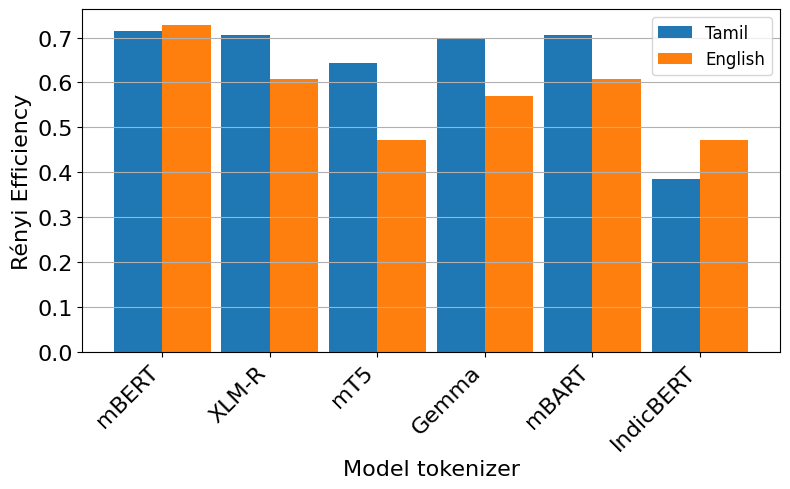

In [8]:
tamil_results = analyze_sentence_level(Flores_Tamil_df, tokenizers, sentence_col='sentence')
english_df = Flores_df[['sentence_eng']].copy()
english_df.columns = ['sentence']
english_results = analyze_sentence_level(english_df, tokenizers, sentence_col='sentence')

tamil_renyi = compute_corpus_renyi_per_tokenizer(Flores_Tamil_df, tokenizers, vocabs, sentence_col='sentence', alpha=2)
english_renyi = compute_corpus_renyi_per_tokenizer(english_df, tokenizers, vocabs, sentence_col='sentence', alpha=2)

plot_corpus_renyi(tamil_results, english_results, tamil_renyi, english_renyi, tokenizers)

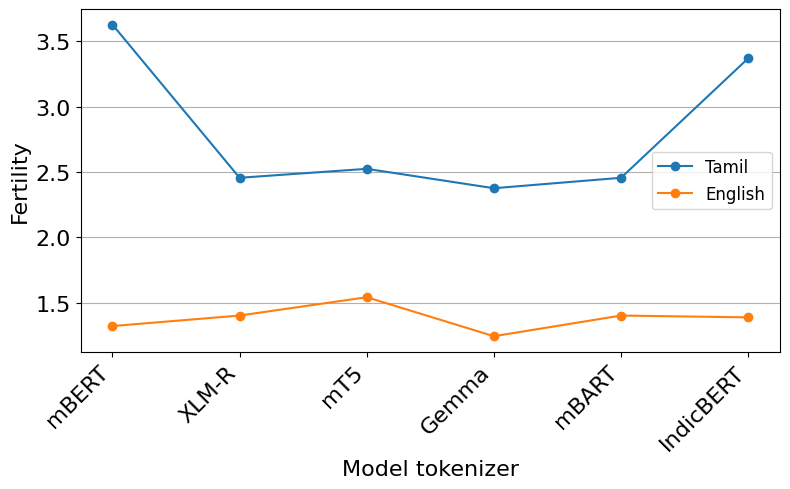

In [9]:
plot_compression_fertility(tokenizers, tamil_results, english_results, metric="fertility")

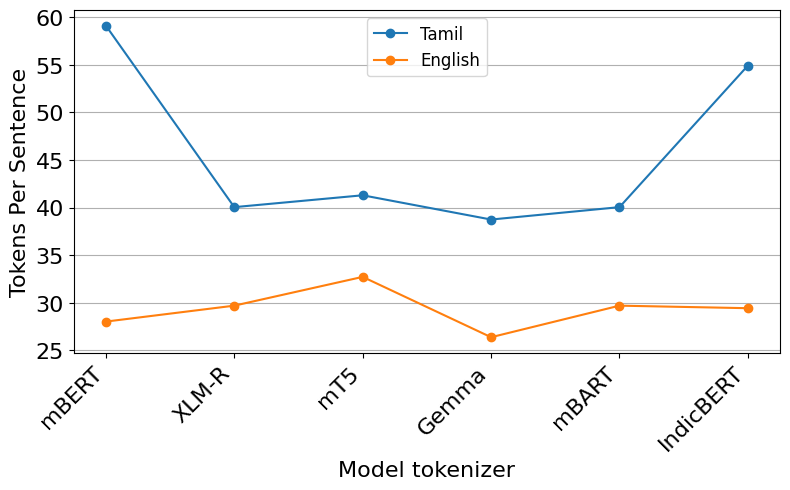

In [10]:
plot_compression_fertility(tokenizers, tamil_results, english_results, metric="tokens_per_sentence")

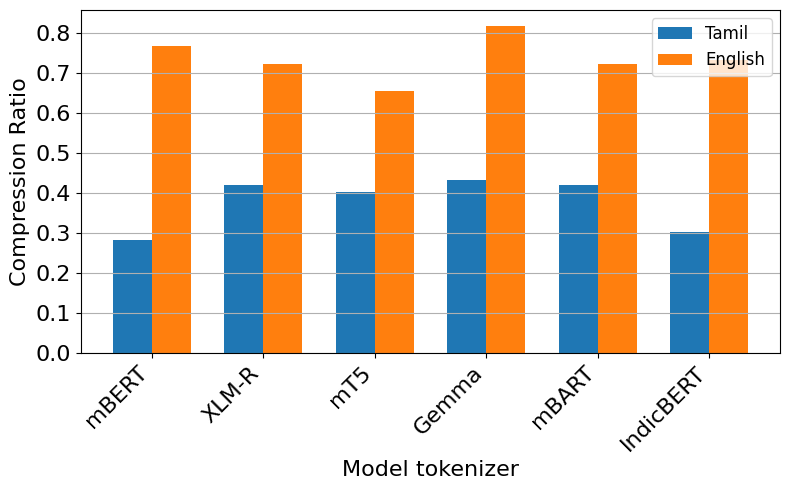

In [11]:
plot_compression_fertility(tokenizers, tamil_results, english_results, metric="compression_ratio")

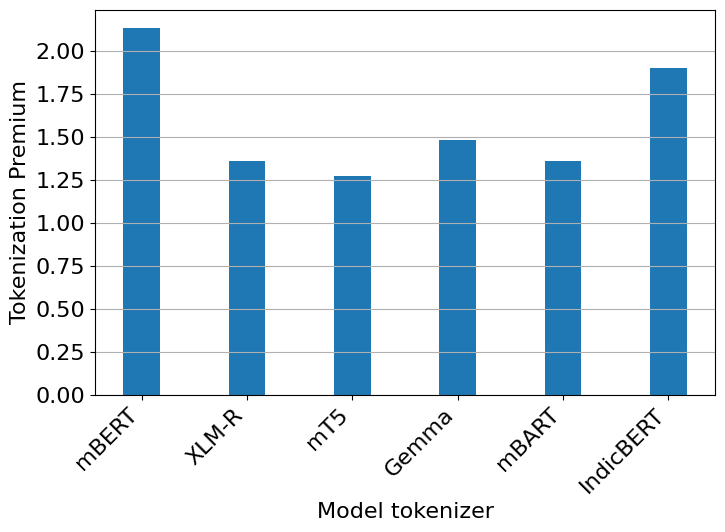

In [12]:
plot_tokenization_premium(tokenizers, tamil_results, english_results)

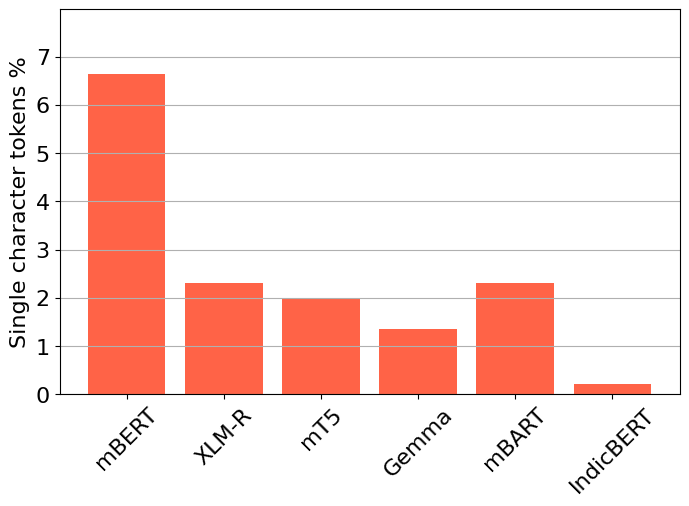

In [13]:
tokenizer_names = ["mBert Tokenizer", "XLM-R Tokenizer", "mt-5 Tokenizer", "Gemma Tokenizer", "mBART Tokenizer", "IndicBert Tokenizer"]
tokenizer = list(tokenizers.keys())
vocab_lists = [
    bert_vocab,
    xlmr_vocab,
    mt5_vocab,
    gemma_vocab,
    mbart_vocab,
    indic_bert_vocab
]

percentages = [percent_vowel_start(vocab, tokenizer_name) for vocab, tokenizer_name in zip(vocab_lists, tokenizer_names)]

plt.figure(figsize=(8,5))
plt.bar(tokenizer, percentages, color='tomato')
plt.ylabel("Single character tokens %", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.ylim(0, max(percentages)*1.2)
plt.grid(axis='y')
plt.savefig('SingleCharacterPercentage.jpg', dpi=1000, bbox_inches='tight')
plt.show()

# Evaluate Morphological Alignment

## Evaluation on MorphScore Dataset

In [14]:
Morph_data_Tamil = dfs['tam_taml']
Morph_data_English = dfs['eng_latn'][:5000]
Morph_data_German = dfs['deu_latn'][:5000]
Morph_data_Spanish = dfs['spa_latn'][:5000]
Morph_data_Turkish = dfs['tur_latn'][:5000]
Morph_data_French = dfs['fra_latn'][:5000]
Morph_data_Arabic = dfs['arb_latn'][:5000]
Morph_data_Finnish = dfs['fin_latn'][:5000]
Morph_data_Dutch = dfs['nld_latn'][:5000]

In [15]:
tokenizer_dict = {
    "Gemma": gemma_tokenizer,
    "mBERT": bert_tokenizer,
    "IndicBERT": indic_bert,
    "XLMR": xlmr_tokenizer,
    "mBART": mbart_tokenizer,
    "mT5": mt5_tokenizer,
}

tokenization_function(Morph_data_Tamil)
tokenization_function(Morph_data_English)
tokenization_function(Morph_data_German)
tokenization_function(Morph_data_Spanish)
tokenization_function(Morph_data_Turkish)
tokenization_function(Morph_data_French)
tokenization_function(Morph_data_Arabic)
tokenization_function(Morph_data_Finnish)
tokenization_function(Morph_data_Dutch)

/local/jobs/u17842_11888383/ipykernel_1627985/570328222.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, name] = df['wordform'].apply(lambda x: tokenizer.tokenize(str(x)))
/local/jobs/u17842_11888383/ipykernel_1627985/570328222.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, name] = df['wordform'].apply(lambda x: tokenizer.tokenize(str(x)))
/local/jobs/u17842_11888383/ipykernel_1627985/570328222.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [16]:
tokenizer_cols = ['Gemma', 'mBERT', 'XLMR', 'mBART', 'mT5']
language_dfs = {
    "Tamil": Morph_data_Tamil,
    "English": Morph_data_English,
    "German": Morph_data_German,
    "Spanish": Morph_data_Spanish,
    "French": Morph_data_French,
    "Turkish": Morph_data_Turkish,
    "Arabic": Morph_data_Arabic,
    "Finnish": Morph_data_Finnish,
    "Dutch": Morph_data_Dutch,
}
precision_table = {}
recall_table = {}
f1_table = {}
accuracy_table = {}

for lang, df in language_dfs.items():
    morph_alignment = compute_morphological_alignment(df, tokenizer_cols)
    recall_table[lang] = {tok: morph_alignment.loc[tok,"Recall"] for tok in tokenizer_cols}
    precision_table[lang] = {tok: morph_alignment.loc[tok,"Precision"] for tok in tokenizer_cols}
    f1_table[lang] = {tok: morph_alignment.loc[tok,"F1 Score"] for tok in tokenizer_cols}
    accuracy_table[lang] = {tok: morph_alignment.loc[tok,"Accuracy"] for tok in tokenizer_cols}

recall_df = pd.DataFrame.from_dict(recall_table, orient="index")
precision_df = pd.DataFrame.from_dict(precision_table, orient="index")
f1_df = pd.DataFrame.from_dict(f1_table, orient="index")
accuracy_df = pd.DataFrame.from_dict(accuracy_table, orient="index")

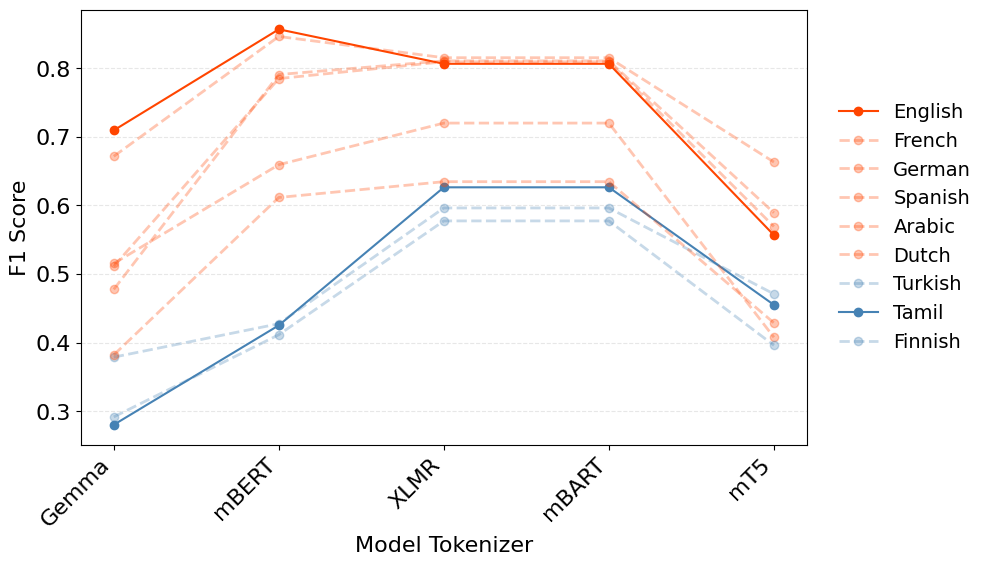

In [17]:
def Plot_Morphological_Alignment(dataframe, Title):
    highlight_langs = ['English', 'Tamil']
    
    plt.figure(figsize=(10, 5))
    for lang in dataframe.index:
        if lang in ['Tamil', 'Finnish', 'Turkish']:
            if lang == 'Tamil':
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='steelblue')
            else:
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='steelblue', alpha=0.3, linestyle='--', linewidth=2)
        else:
            if lang == 'English':
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='orangered')
            else:
                plt.plot(tokenizer_cols, dataframe.loc[lang], marker='o', label=lang, color='orangered', alpha=0.3, linestyle='--', linewidth=2)

    plt.xlabel("Model Tokenizer", fontsize=16)
    plt.ylabel(Title, fontsize=16)
    
    plt.xticks(fontsize=16, rotation=45, ha='right')
    plt.yticks(fontsize=16)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    scores = [dataframe.loc[label]['mBERT'] for label in labels]
    sorted_items = sorted(zip(scores, handles, labels), reverse=True)
    sorted_handles, sorted_labels = zip(*[(h, l) for _, h, l in sorted_items])
    
    plt.legend(sorted_handles, sorted_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.savefig('MorphologyPlot.jpg', dpi=1000, bbox_inches='tight')
    plt.show()

Plot_Morphological_Alignment(f1_df, "F1 Score")

## Evaluation on Custom Dataset

In [18]:
df = pd.read_csv("/mnt/vast-react/projects/react_ag_beinborn_students/u17842/Datasets/Single_Suffix_Verb_Noun_Chunks/SegmentorTrainingCorpus.csv", index_col=None)
Custom_Morph_Dataset = df[['Word', 'Root Suffix Morphology Altered']].copy()
Custom_Morph_Dataset = Custom_Morph_Dataset.rename(columns={'Word':'wordform'})
Custom_Morph_Dataset['stem'] = Custom_Morph_Dataset['Root Suffix Morphology Altered'].apply(lambda x: x.strip().split()[0])
Custom_Morph_Dataset['following_part'] = Custom_Morph_Dataset['Root Suffix Morphology Altered'].apply(lambda x: x.strip().split()[-1])
Custom_Morph_Dataset = Custom_Morph_Dataset.drop({'Root Suffix Morphology Altered'}, axis=1)
Custom_Dataset = Custom_Morph_Dataset.copy()
Custom_Dataset.shape

(503292, 3)

In [19]:
tokenization_function(Custom_Dataset)

precision_table = {}
recall_table = {}
f1_table = {}
accuracy_table = {}

morph_alignment = compute_morphological_alignment(Custom_Dataset, tokenizer_cols)
recall_table['tamil'] = {tok: morph_alignment.loc[tok,"Recall"] for tok in tokenizer_cols}
precision_table['tamil'] = {tok: morph_alignment.loc[tok,"Precision"] for tok in tokenizer_cols}
f1_table['tamil'] = {tok: morph_alignment.loc[tok,"F1 Score"] for tok in tokenizer_cols}
accuracy_table['tamil'] = {tok: morph_alignment.loc[tok,"Accuracy"] for tok in tokenizer_cols}

recall_df = pd.DataFrame.from_dict(recall_table, orient="index")
precision_df = pd.DataFrame.from_dict(precision_table, orient="index")
f1_df = pd.DataFrame.from_dict(f1_table, orient="index")
accuracy_df = pd.DataFrame.from_dict(accuracy_table, orient="index")

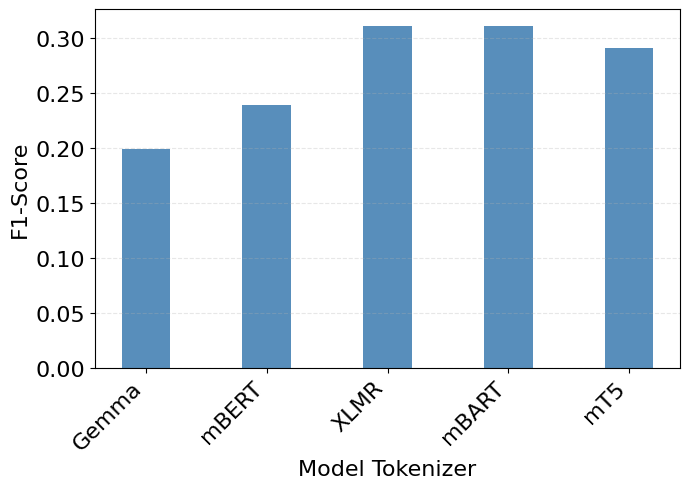

In [20]:
plt.figure(figsize=(7, 5))
plt.bar(tokenizer_cols, f1_df.loc['tamil'], width = 0.40, color='steelblue', alpha=0.9)
plt.ylabel('F1-Score', fontsize=16)
plt.xlabel('Model Tokenizer', fontsize=16)
plt.xticks(fontsize=16, rotation=45, ha='right')
plt.yticks(fontsize=16)
plt.tight_layout()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend()
plt.savefig('MorphologyAlignmentCustomData.jpg', dpi=1000, bbox_inches='tight')
plt.show()

# Influence Evaluation

## Evaluation of Influence of Tokenizer Hyperparameters

In [21]:
tokenizer_dict = {
    "Gemma": gemma_tokenizer,
    "mBERT": bert_tokenizer,
    "IndicBERT": indic_bert,
    "XLMR": xlmr_tokenizer,
    "mBART": mbart_tokenizer,
    "mT5": mt5_tokenizer,
}
tokenizer_cols = ["3K","5K","8K","10K","20K","32K"]

In [22]:
bbpe3, unigram3, wordpiece3 = get_morphological_tokenizers("3", "IndicCorpus")
bbpe5, unigram5, wordpiece5 = get_morphological_tokenizers("5", "IndicCorpus")
bbpe8, unigram8, wordpiece8 = get_morphological_tokenizers("8", "IndicCorpus")
bbpe10, unigram10, wordpiece10 = get_morphological_tokenizers("10", "IndicCorpus")
bbpe20, unigram20, wordpiece20 = get_morphological_tokenizers("20", "IndicCorpus")
bbpe32, unigram32, wordpiece32 = get_morphological_tokenizers("32", "IndicCorpus")

CSS_bbpe3, CSS_unigram3, CSS_wordpiece3 = get_morphological_tokenizers("3", "CSSIndicCorpus")
CSS_bbpe5, CSS_unigram5, CSS_wordpiece5 = get_morphological_tokenizers("5", "CSSIndicCorpus")
CSS_bbpe8, CSS_unigram8, CSS_wordpiece8 = get_morphological_tokenizers("8", "CSSIndicCorpus")
CSS_bbpe10, CSS_unigram10, CSS_wordpiece10 = get_morphological_tokenizers("10", "CSSIndicCorpus")
CSS_bbpe20, CSS_unigram20, CSS_wordpiece20 = get_morphological_tokenizers("20", "CSSIndicCorpus")
CSS_bbpe32, CSS_unigram32, CSS_wordpiece32 = get_morphological_tokenizers("32", "CSSIndicCorpus")

SSS_bbpe3, SSS_unigram3, SSS_wordpiece3 = get_morphological_tokenizers("3", "SSSIndicCorpus")
SSS_bbpe5, SSS_unigram5, SSS_wordpiece5 = get_morphological_tokenizers("5", "SSSIndicCorpus")
SSS_bbpe8, SSS_unigram8, SSS_wordpiece8 = get_morphological_tokenizers("8", "SSSIndicCorpus")
SSS_bbpe10, SSS_unigram10, SSS_wordpiece10 = get_morphological_tokenizers("10", "SSSIndicCorpus")
SSS_bbpe20, SSS_unigram20, SSS_wordpiece20 = get_morphological_tokenizers("20", "SSSIndicCorpus")
SSS_bbpe32, SSS_unigram32, SSS_wordpiece32 = get_morphological_tokenizers("32", "SSSIndicCorpus")

In [23]:
BBPE_Indic_Dict = {
    "3K":bbpe3, "5K":bbpe5, "8K":bbpe8, "10K":bbpe10, "20K":bbpe20, "32K":bbpe32,
}
Unigram_Indic_Dict = {
    "3K":unigram3, "5K":unigram5, "8K":unigram8, "10K":unigram10, "20K":unigram20, "32K":unigram32,
}
Wordpiece_Indic_Dict = {
    "3K":wordpiece3, "5K":wordpiece5, "8K":wordpiece8, "10K":wordpiece10, "20K":wordpiece20, "32K":wordpiece32,
}

BBPE_SSS_Indic_Dict = {
    "3K":SSS_bbpe3, "5K":SSS_bbpe5, "8K":SSS_bbpe8, "10K":SSS_bbpe10, "20K":SSS_bbpe20, "32K":SSS_bbpe32,
}
Unigram_SSS_Indic_Dict = {
    "3K":SSS_unigram3, "5K":SSS_unigram5, "8K":SSS_unigram8, "10K":SSS_unigram10, "20K":SSS_unigram20, "32K":SSS_unigram32,
}
Wordpiece_SSS_Indic_Dict = {
    "3K":SSS_wordpiece3, "5K":SSS_wordpiece5, "8K":SSS_wordpiece8, "10K":SSS_wordpiece10, "20K":SSS_wordpiece20, "32K":SSS_wordpiece32,
}

BBPE_CSS_Indic_Dict = {
    "3K":CSS_bbpe3, "5K":CSS_bbpe5, "8K":CSS_bbpe8, "10K":CSS_bbpe10, "20K":CSS_bbpe20, "32K":CSS_bbpe32,
}
Unigram_CSS_Indic_Dict = {
    "3K":CSS_unigram3, "5K":CSS_unigram5, "8K":CSS_unigram8, "10K":CSS_unigram10, "20K":CSS_unigram20, "32K":CSS_unigram32,
}
Wordpiece_CSS_Indic_Dict = {
    "3K":CSS_wordpiece3, "5K":CSS_wordpiece5, "8K":CSS_wordpiece8, "10K":CSS_wordpiece10, "20K":CSS_wordpiece20, "32K":CSS_wordpiece32,
}


IndicBBPETokenized, IndicUnigramTokenized, IndicWordpieceTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(IndicBBPETokenized, BBPE_Indic_Dict)
apply_tokenizer_dict(IndicUnigramTokenized, Unigram_Indic_Dict)
apply_tokenizer_dict(IndicWordpieceTokenized, Wordpiece_Indic_Dict, is_wordpiece=True)

SSSBBPETokenized, SSSUnigramTokenized, SSSWordpieceTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(SSSBBPETokenized, BBPE_SSS_Indic_Dict)
apply_tokenizer_dict(SSSUnigramTokenized, Unigram_SSS_Indic_Dict)
apply_tokenizer_dict(SSSWordpieceTokenized, Wordpiece_SSS_Indic_Dict, is_wordpiece=True)

CSSBBPETokenized, CSSUnigramTokenized, CSSWordpieceTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(CSSBBPETokenized, BBPE_CSS_Indic_Dict)
apply_tokenizer_dict(CSSUnigramTokenized, Unigram_CSS_Indic_Dict)
apply_tokenizer_dict(CSSWordpieceTokenized, Wordpiece_CSS_Indic_Dict, is_wordpiece=True)

## Influence of Tokenizer Strategy

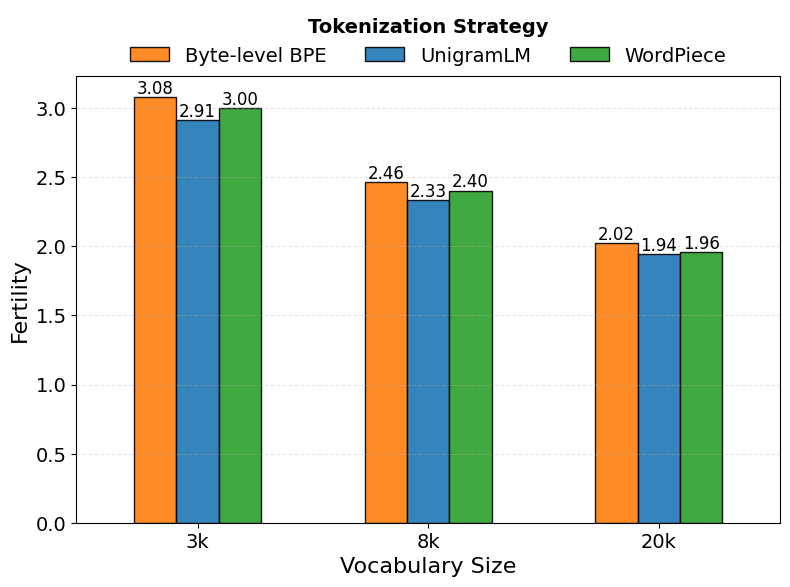

In [24]:
Unique_3k_df, bbpe3_vocab, unigram3_vocab, wordpiece3_vocab = custom_tokenize_dataset(unique_df, "Unique_3k.txt", "3k", 'Words',"IndicCorpus",False)
Unique_8k_df, bbpe8_vocab, unigram8_vocab, wordpiece8_vocab = custom_tokenize_dataset(unique_df, "Unique_8k.txt", "8k", 'Words',"IndicCorpus",False)
Unique_20k_df, bbpe20_vocab, unigram20_vocab, wordpiece20_vocab = custom_tokenize_dataset(unique_df, "Unique_20k.txt", "20k", 'Words', "IndicCorpus",False)

fertility_summary = pd.DataFrame({
    'Byte-level BPE': [
        Unique_3k_df['Token Length BBPE'].mean(),
        Unique_8k_df['Token Length BBPE'].mean(),
        Unique_20k_df['Token Length BBPE'].mean()
    ],
    'UnigramLM': [
        Unique_3k_df['Token Length Unigram'].mean(),
        Unique_8k_df['Token Length Unigram'].mean(),
        Unique_20k_df['Token Length Unigram'].mean()
    ],
    'WordPiece': [
        Unique_3k_df['Token Length WordPiece'].mean(),
        Unique_8k_df['Token Length WordPiece'].mean(),
        Unique_20k_df['Token Length WordPiece'].mean()
    ]
}, index=['3k','8k','20k'])

ax = fertility_summary.plot(kind='bar',
                            color=['#ff7f0e', '#1f77b4', '#2ca02c'],
                            figsize=(8,6),
                            edgecolor='black',
                            alpha=0.9,
                            width=0.55)

ax.set_xlabel('Vocabulary Size', fontsize=16)
ax.set_ylabel('Fertility', fontsize=16)
ax.set_xticklabels(fertility_summary.index, rotation=0, fontsize=14) 
ax.tick_params(axis='y', labelsize=14)
ax.legend(
    title='Tokenization Strategy',
    title_fontproperties={'weight': 'bold', 'size': 14},
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=False
)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=12)

plt.tight_layout()
plt.savefig('FertilityTokenizerComparisons.png', dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
strategy_cols = ["Byte-BPE", "UnigramLM", "Wordpiece"]
vocab_sizes = [3000, 8000, 20000]
f1_results = {vocab: {} for vocab in vocab_sizes}

print("Processing 3k vocab...")
IndicTokenizerComparison_3k, IndicTokenizerComparison_8k, IndicTokenizerComparison_20k = Morph_data_Tamil.copy(), Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
IndicTokenizerComparison_3k["Wordpiece"] = IndicTokenizerComparison_3k["wordform"].apply(lambda w: wordpiece3.encode(w, add_special_tokens=False).tokens).apply(remove_bert_underscore)
IndicTokenizerComparison_3k["Byte-BPE"] = IndicTokenizerComparison_3k["wordform"].apply(lambda w: bbpe3.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)
IndicTokenizerComparison_3k["UnigramLM"] = IndicTokenizerComparison_3k["wordform"].apply(lambda w: unigram3.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)

Corpus_df_3k = {"Corpus": IndicTokenizerComparison_3k}
f1_df_3k, _ = Morphological_analysis(Corpus_df_3k)
f1_results[3000] = f1_df_3k.loc["Corpus"].to_dict()

print("Processing 8k vocab...")
IndicTokenizerComparison_8k = Morph_data_Tamil.copy()
IndicTokenizerComparison_8k["Wordpiece"] = IndicTokenizerComparison_8k["wordform"].apply(lambda w: wordpiece8.encode(w, add_special_tokens=False).tokens).apply(remove_bert_underscore)
IndicTokenizerComparison_8k["Byte-BPE"] = IndicTokenizerComparison_8k["wordform"].apply(lambda w: bbpe8.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)
IndicTokenizerComparison_8k["UnigramLM"] = IndicTokenizerComparison_8k["wordform"].apply(lambda w: unigram8.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)

Corpus_df_8k = {"Corpus": IndicTokenizerComparison_8k}
f1_df_8k, _ = Morphological_analysis(Corpus_df_8k, strategy_cols)
f1_results[8000] = f1_df_8k.loc["Corpus"].to_dict()

print("Processing 20k vocab...")
IndicTokenizerComparison_20k = Morph_data_Tamil.copy()
IndicTokenizerComparison_20k["Wordpiece"] = IndicTokenizerComparison_20k["wordform"].apply(lambda w: wordpiece20.encode(w, add_special_tokens=False).tokens).apply(remove_bert_underscore)
IndicTokenizerComparison_20k["Byte-BPE"] = IndicTokenizerComparison_20k["wordform"].apply(lambda w: bbpe20.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)
IndicTokenizerComparison_20k["UnigramLM"] = IndicTokenizerComparison_20k["wordform"].apply(lambda w: unigram20.encode(w, out_type=str)).apply(remove_sentencepiece_underscore)

Corpus_df_20k = {"Corpus": IndicTokenizerComparison_20k}
f1_df_20k, _ = Morphological_analysis(Corpus_df_20k, strategy_cols)
f1_results[20000] = f1_df_20k.loc["Corpus"].to_dict()

f1_summary = pd.DataFrame({
    'Byte-level BPE': [
        f1_results[3000]['Byte-BPE'],
        f1_results[8000]['Byte-BPE'],
        f1_results[20000]['Byte-BPE']
    ],
    'UnigramLM': [
        f1_results[3000]['UnigramLM'],
        f1_results[8000]['UnigramLM'],
        f1_results[20000]['UnigramLM']
    ],
    'WordPiece': [
        f1_results[3000]['Wordpiece'],
        f1_results[8000]['Wordpiece'],
        f1_results[20000]['Wordpiece']
    ]
}, index=['3k','8k','20k'])

ax = f1_summary.plot(kind='bar', 
                     figsize=(8, 6),
                     color=['#ff7f0e', '#1f77b4', '#2ca02c'],
                     edgecolor='black',
                     alpha=0.9,
                     width=0.55,
                     label=False)

ax.set_xlabel('Vocabulary Size', fontsize=16)
ax.set_ylabel('F1 Score', fontsize=16)
ax.set_xticklabels(f1_summary.index, rotation=0, fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(0.0, 0.85) 
ax.legend(
    title='Tokenization Strategy',
    title_fontproperties={'weight': 'bold', 'size': 14},
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=False
)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=12)

plt.tight_layout()
plt.savefig('F1ScoreTokenizersComparisons.png', dpi=300, bbox_inches='tight')
plt.show()

## Influence of Training Corpus

In [102]:
def obtain_trained_tokenizers(vocab_size, corpus):
    bpe_path = f"/mnt/vast-react/projects/react_ag_beinborn_students/u17842/Tokenizer/Balanced/{corpus}/{vocab_size}/tamil_sentencepiece_byte_bpe_{vocab_size}k.model"
    unigram_path = f'/mnt/vast-react/projects/react_ag_beinborn_students/u17842/Tokenizer/Balanced/{corpus}/{vocab_size}/tamil_sentencepiece_unigram_{vocab_size}k.model'
    tok_bpe = spm.SentencePieceProcessor()
    tok_bpe.load(bpe_path)
    tok_unigram = spm.SentencePieceProcessor()
    tok_unigram.load(unigram_path)
    tok_wordpiece = Tokenizer.from_file(f"/mnt/vast-react/projects/react_ag_beinborn_students/u17842/Tokenizer/Balanced/{corpus}/{vocab_size}/tamil_wordpiece_{vocab_size}k.json")
    return tok_bpe, tok_unigram, tok_wordpiece

def custom_tokenize_dataset(Corpus_df, vocab_size: str, corpus: str):
    bpe_tokenizer, unigram_tokenizer, wordpiece_tokenizer = obtain_trained_tokenizers(vocab_size, corpus)
    test_sentence_list = Corpus_df['Words'].to_list()
    tokenized_df = pd.DataFrame()
    tokenized_df['Words'] = test_sentence_list
    tokenized_df['BBPE Tokenized'] = [bpe_tokenizer.encode_as_pieces(sent) for sent in test_sentence_list]
    tokenized_df['BBPE Tokenized'] = tokenized_df['BBPE Tokenized'].apply(remove_sentencepiece_underscore)
    tokenized_df['Unigram Tokenized'] = [unigram_tokenizer.encode_as_pieces(sent) for sent in test_sentence_list]
    tokenized_df['Unigram Tokenized'] = tokenized_df['Unigram Tokenized'].apply(remove_sentencepiece_underscore)
    tokenized_df['WordPiece Tokenized'] = [(wordpiece_tokenizer.encode(sent)).tokens for sent in test_sentence_list]
    tokenized_df['WordPiece Tokenized'] = tokenized_df['WordPiece Tokenized'].apply(remove_bert_characters).apply(remove_sepcial_tokens)
    tokenized_df['Token Length BBPE'] = [len(tokenized_sentence) for tokenized_sentence in tokenized_df['BBPE Tokenized']]
    tokenized_df['Token Length Unigram'] = [len(tokenized_sentence) for tokenized_sentence in tokenized_df['Unigram Tokenized']]
    tokenized_df['Token Length WordPiece'] = [len(tokenized_sentence) for tokenized_sentence in tokenized_df['WordPiece Tokenized']]
    return tokenized_df

In [23]:
balanced_wiki_bpe3, balanced_wiki_unigram3, balanced_wiki_wordpiece3 = obtain_trained_tokenizers("3k","Wiki")
balanced_Indic_bpe3, balanced_Indic_unigram3, balanced_Indic_wordpiece3 = obtain_trained_tokenizers("3k","Indic")

balanced_wiki_bpe8, balanced_wiki_unigram8, balanced_wiki_wordpiece8 = obtain_trained_tokenizers("8k","Wiki")
balanced_Indic_bpe8, balanced_Indic_unigram8, balanced_Indic_wordpiece8 = obtain_trained_tokenizers("8k","Indic")

balanced_wiki_bpe20, balanced_wiki_unigram20, balanced_wiki_wordpiece20 = obtain_trained_tokenizers("20k","Wiki")
balanced_Indic_bpe20, balanced_Indic_unigram20, balanced_Indic_wordpiece20 = obtain_trained_tokenizers("20k","Indic")

BBPEWikitokenizers = {
    "3K":balanced_wiki_bpe3, "8K":balanced_wiki_bpe8, "20K":balanced_wiki_bpe20
}
UnigramWikitokenizers = {
    "3K":balanced_wiki_unigram3, "8K":balanced_wiki_unigram8, "20K":balanced_wiki_unigram20
}
WordpieceWikitokenizers = {
    "3K":balanced_wiki_wordpiece3, "8K":balanced_wiki_wordpiece8, "20K":balanced_wiki_wordpiece20
}

BBPEIndictokenizers = {
    "3K":balanced_Indic_bpe3, "8K":balanced_Indic_bpe8, "20K":balanced_Indic_bpe20
}
UnigramIndictokenizers = {
    "3K":balanced_Indic_unigram3, "8K":balanced_Indic_unigram8, "20K":balanced_Indic_unigram20
}
WordpieceIndictokenizers = {
    "3K":balanced_Indic_wordpiece3, "8K":balanced_Indic_wordpiece8, "20K":balanced_Indic_wordpiece20
}

BalancedBBPEWikiTokenized, BalancedUnigramWikiTokenized, BalancedWordpieceWikiTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(BalancedBBPEWikiTokenized, BBPEWikitokenizers)
apply_tokenizer_dict(BalancedUnigramWikiTokenized, UnigramWikitokenizers)
apply_tokenizer_dict(BalancedWordpieceWikiTokenized, WordpieceWikitokenizers, is_wordpiece=True)

BalancedBBPEIndicTokenized, BalancedUnigramIndicTokenized, BalancedWordpieceIndicTokenized = Morph_data_Tamil.copy(),Morph_data_Tamil.copy(), Morph_data_Tamil.copy()
apply_tokenizer_dict(BalancedBBPEIndicTokenized, BBPEIndictokenizers)
apply_tokenizer_dict(BalancedUnigramIndicTokenized, UnigramIndictokenizers)
apply_tokenizer_dict(BalancedWordpieceIndicTokenized, WordpieceIndictokenizers, is_wordpiece=True)

In [24]:
tokenizer_cols = ['3K', '8K', '20K']
Balanced_Wiki_dfs = {
    "BBPE": BalancedBBPEWikiTokenized,
    "Unigram": BalancedUnigramWikiTokenized,
    "Wordpiece": BalancedWordpieceWikiTokenized,
}
Balanced_Indic_dfs = {
    "BBPE": BalancedBBPEIndicTokenized,
    "Unigram": BalancedUnigramIndicTokenized,
    "Wordpiece": BalancedWordpieceIndicTokenized,
}
indic_f1, indic_accuracy = Morphological_analysis(Balanced_Indic_dfs, tokenizer_cols)
wiki_f1, wiki_accuracy = Morphological_analysis(Balanced_Wiki_dfs, tokenizer_cols)

Wiki_tokenized = custom_tokenize_dataset(unique_df, "3k", "Wiki")
Indic_tokenized = custom_tokenize_dataset(unique_df, "3k", "Indic")

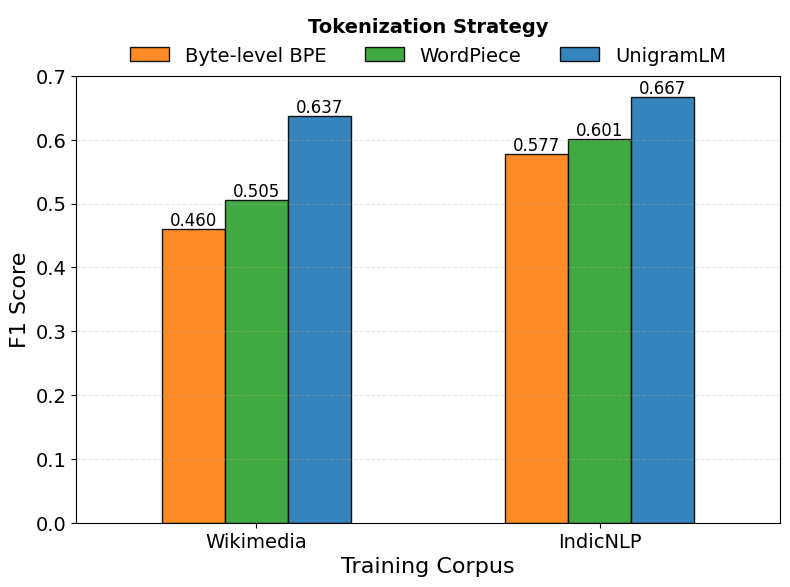

In [25]:
vocab = "3K"
wiki_f1 = wiki_f1.rename(index={'BBPE': 'Byte-level BPE'})
indic_f1 = indic_f1.rename(index={'BBPE': 'Byte-level BPE'})

tokenizers = ['Byte-level BPE', 'Wordpiece', 'UnigramLM']
f1_corpus_summary = pd.DataFrame({
    'Byte-level BPE': [wiki_f1.loc['Byte-level BPE', vocab],
                       indic_f1.loc['Byte-level BPE', vocab]],
    'WordPiece':      [wiki_f1.loc['Wordpiece', vocab],
                       indic_f1.loc['Wordpiece', vocab]],
    'UnigramLM':        [wiki_f1.loc['Unigram', vocab],
                       indic_f1.loc['Unigram', vocab]],
    
},
index=['Wikimedia', 'IndicNLP'])

ax = f1_corpus_summary.plot(kind='bar',
                            figsize=(8,6),
                            edgecolor='black',
                            color=['#ff7f0e', '#2ca02c', '#1f77b4'], 
                            alpha=0.9,
                            width=0.55)

ax.set_xlabel('Training Corpus', fontsize=16)
ax.set_ylabel('F1 Score', fontsize=16)
ax.set_xticklabels(f1_corpus_summary.index, rotation=0, fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(
    title='Tokenization Strategy',
    title_fontproperties={'weight': 'bold', 'size': 14},
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=False
)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=12)

plt.tight_layout()
plt.savefig('Corpus_vs_F1_Tokenizers.jpg', dpi=1000, bbox_inches='tight')
plt.show()

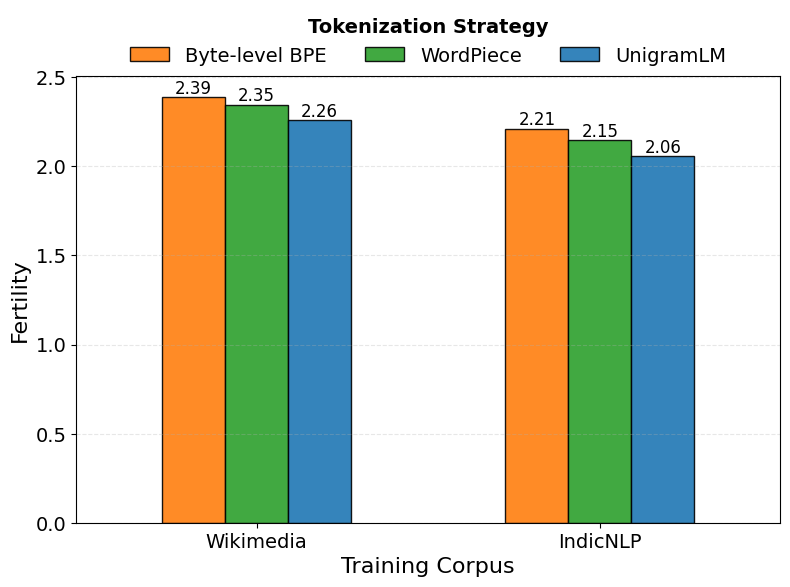

In [26]:
wiki_fert = {tok: df['3K'].apply(lambda x: len(x)).mean() for tok, df in Balanced_Wiki_dfs.items()} 
indic_fert = {tok: df['3K'].apply(lambda x: len(x)).mean() for tok, df in Balanced_Indic_dfs.items()}

wiki_fert = {'Byte-level BPE': wiki_fert['BBPE'],
             'WordPiece':      wiki_fert['Wordpiece'],
             'Unigram':        wiki_fert['Unigram']}

indic_fert = {'Byte-level BPE': indic_fert['BBPE'],
              'WordPiece':      indic_fert['Wordpiece'],
              'Unigram':        indic_fert['Unigram']}

fert_corpus_summary = pd.DataFrame({
    'Byte-level BPE': [wiki_fert['Byte-level BPE'], indic_fert['Byte-level BPE']],
    'WordPiece':      [wiki_fert['WordPiece'],      indic_fert['WordPiece']],
    'UnigramLM':        [wiki_fert['Unigram'],         indic_fert['Unigram']]
},
index=['Wikimedia','IndicNLP'])
ax = fert_corpus_summary.plot(kind='bar',
                              figsize=(8,6),
                              color=['#ff7f0e', '#2ca02c', '#1f77b4'], 
                              edgecolor='black',
                              alpha=0.9,
                              width=0.55)

ax.set_xlabel('Training Corpus', fontsize=16)
ax.set_ylabel('Fertility', fontsize=16)
ax.set_xticklabels(fert_corpus_summary.index, rotation=0, fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(
    title='Tokenization Strategy',
    title_fontproperties={'weight': 'bold', 'size': 14},
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.17),
    ncol=3,
    frameon=False
)
ax.grid(axis='y', alpha=0.3, linestyle='--')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=12)

plt.tight_layout()
plt.savefig('Corpus_vs_Fertility_Tokenizers.jpg', dpi=1000, bbox_inches='tight')
plt.show()

## Influence of morphological suffixes

In [29]:
morphscore_df = morphscore_ds['train'].to_pandas()
features_to_select = ['wordform', 'stem', 'following_part', 'language']
Morph_data_Tamil = morphscore_df[morphscore_df['language'] == 'tam_taml'][['wordform','stem','following_part']].reset_index(drop=True)

In [42]:
loaded_tokenizers = {
    "mBERT": bert_tokenizer,
    "XLMR": xlmr_tokenizer,
    "mT5": mt5_tokenizer,
    "Gemma": gemma_tokenizer,
    "mBART": mbart_tokenizer,
}
tokenizer_map = {
    "Gemma": "google/gemma-3-1b-it",
    "mBERT": "bert-base-multilingual-cased",
    "XLMR":  "xlm-roberta-base",
    "mT5":   "google/mt5-base",
    "mBART": "facebook/mbart-large-50-many-to-many-mmt"
}
raw_suffixes = ['ை', 'ா', 'க்', 'ைப்', 'ப்', 'ாக', 'ைக்', 'கள்', 'க்கு', 'ைத்', 'த்', 'ுக்கு', 'ைச்', 'ில்', 'யின்', 'ாய்', 'யில்', 'களை', 'ச்', 
                'ான', 'ுடன்', 'ால்', 'த்தில்', 'களில்', 'களின்', 'த்தை', 'யாக', 'களுக்கு', 'த்தின்', 'ிடம்', 'யுடன்', 'ங்கள்', 'களைப்', 'யால்', 
                'களைக்', 'ாக்', 'க்குப்', 'ாகக்', 'களால்', 'ாகப்', 'த்துக்கு', 'களுடன்', 'ோடு', 'ுக்குப்', 'வின்', 'ாகத்', 'யான', 'னின்', 'ரின்', 
                'யிலிருந்து', 'லே', 'ாப்', 'களைத்', 'ிலிருந்து', 'ங்களை', 'த்துடன்', 'த்தைக்', 'த்தைப்', 'ாத்', 'த்தைச்', 'க்குத்', 'க்குக்', 'ங்களில்', 
                'க்குச்', 'யோடு', 'த்திலிருந்து', 'த்தைத்', 'ாலே', 'ட்', 'த்தால்', 'ாகச்', 'ுக்குத்', 'யிடம்', 'களைச்', 'ுக்குக்', 'ங்களின்', 'ாங்', 'வில்', 
                'வுக்கு', 'ாட்', 'ங்களுக்கு', 'ுக்குச்', 'களோடு', 'லின்', 'த்தோடு', 'களுக்குப்', 'ங்', 'ங்களைக்', 'ங்களைப்', 'ுடைய', 'வுடன்', 'யாகக்', 
                'களுக்காக', 'ின்', 'களிலிருந்து', 'து', 'களிடம்', 'யாகப்', 'த்துக்குப்', 'ிடமிருந்து']
seen = set()
suffix_list = []
for s in raw_suffixes:
    if isinstance(s, str):
        s_clean = s.strip()
        if s_clean and s_clean not in seen:
            suffix_list.append(s_clean)
            seen.add(s_clean)

print("Suffixes to add:", len(suffix_list))
tokenizers_original = {}
tokenizers_added = {}

for name, tok in loaded_tokenizers.items():
    tokenizers_original[name] = tok
    tokenizers_added[name] = AutoTokenizer.from_pretrained(tokenizer_map[name], trust_remote_code=True)

for name, tok in tokenizers_added.items():
    try:
        added_count = tok.add_tokens(suffix_list, special_tokens=False)
        print(f"{name}: added {added_count} suffix tokens")
    except Exception as e:
        print(f"{name}: add_tokens failed: {e}")


Suffixes to add: 100


/opt/conda/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


mBERT: added 100 suffix tokens
XLMR: added 100 suffix tokens
mT5: added 100 suffix tokens
Gemma: added 100 suffix tokens
mBART: added 100 suffix tokens


In [43]:
df = Morph_data_Tamil.copy()
use_tokenizers = ["Gemma", "mBERT", "XLMR", "mT5", "mBART"]

for name in use_tokenizers:
    tok = tokenizers_original[name]
    col_orig = f"{name}"
    df[col_orig] = df['wordform'].apply(lambda w: safe_tokenize_with_hf(tok, w))
    df[col_orig] = df[col_orig].apply(remove_sentencepiece_underscore).apply(remove_bert_underscore)
    
    tok_added = tokenizers_added[name]
    col_added = f"{name}_Added"
    df[col_added] = df['wordform'].apply(lambda w: safe_tokenize_with_hf(tok_added, w))
    df[col_added] = df[col_added].apply(remove_sentencepiece_underscore).apply(remove_bert_underscore)

In [44]:
def creutz_linden_f1(gold_segmentation, tokenizer_segmentation):
    gold_boundaries = get_boundaries(gold_segmentation)
    token_boundaries = get_boundaries(tokenizer_segmentation)
    if len(tokenizer_segmentation) == 1:
        tp = 1 if len(gold_boundaries)==0 else 0
        fp = 0
        fn = len(gold_boundaries - token_boundaries)
    else:
        tp = len(gold_boundaries.intersection(token_boundaries))
        fp = len(token_boundaries - gold_boundaries)
        fn = len(gold_boundaries - token_boundaries)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    accuracy = (tp / (tp + fn)) if (tp + fn) > 0 else 0.0
    return precision, recall, f1, accuracy
    
def compute_morph_alignment_for_df(df, tokenizer_columns):
    results = {tok: {'precision': [], 'recall': [], 'f1': [], 'accuracy': [], 'length':[], 'total': []} for tok in tokenizer_columns}
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        gold = [row['stem'], row['following_part']]
        for tok in tokenizer_columns:
            tokens = row[tok]
            p, r, f1, acc = creutz_linden_f1(gold, tokens)
            results[tok]['precision'].append(p)
            results[tok]['recall'].append(r)
            results[tok]['f1'].append(f1)
            results[tok]['accuracy'].append(acc)
            results[tok]['total'].append(1)
            results[tok]['length'].append(len(tokens))
    stats = {}
    for tok, vals in results.items():
        n = len(vals['f1'])
        stats[tok] = {
            'Precision': sum(vals['precision'])/n,
            'Recall': sum(vals['recall'])/n,
            'F1 Score': sum(vals['f1'])/n,
            'Accuracy': sum(vals['accuracy'])/n,
            'Avg Tokens': sum(vals['length'])/n,
            'Total': sum(vals['total'])
        }
    return pd.DataFrame(stats).T

tokenizer_cols_original = use_tokenizers
tokenizer_cols_added = [f"{t}_Added" for t in use_tokenizers]

print("Computing for original tokenizers...")
results_orig = compute_morph_alignment_for_df(df, tokenizer_cols_original)

print("Computing for suffix-added tokenizers...")
results_added = compute_morph_alignment_for_df(df, tokenizer_cols_added)

results_combined = pd.concat([results_orig.add_suffix('_Orig'), results_added.add_suffix('_Added')], axis=0, sort=False)
results_combined


Computing for original tokenizers...


100%|██████████| 4499/4499 [00:00<00:00, 12196.31it/s]


Computing for suffix-added tokenizers...


100%|██████████| 4499/4499 [00:00<00:00, 12401.98it/s]


,Precision_Orig,Recall_Orig,F1 Score_Orig,Accuracy_Orig,Avg Tokens_Orig,Total_Orig,Precision_Added,Recall_Added,F1 Score_Added,Accuracy_Added,Avg Tokens_Added,Total_Added
Gemma,0.240205,0.625917,0.326007,0.625917,4.056457,4499.0,NaN,NaN,NaN,NaN,NaN,NaN
mBERT,0.194675,0.651700,0.282053,0.651700,4.746610,4499.0,NaN,NaN,NaN,NaN,NaN,NaN
XLMR,0.269666,0.607913,0.343835,0.607913,3.949989,4499.0,NaN,NaN,NaN,NaN,NaN,NaN
mT5,0.270616,0.588798,0.345311,0.588798,3.769282,4499.0,NaN,NaN,NaN,NaN,NaN,NaN
mBART,0.269666,0.607913,0.343835,0.607913,3.949989,4499.0,NaN,NaN,NaN,NaN,NaN,NaN
Gemma_Added,NaN,NaN,NaN,NaN,NaN,NaN,0.240205,0.625917,0.326007,0.625917,4.056457,4499.0
mBERT_Added,NaN,NaN,NaN,NaN,NaN,NaN,0.194675,0.651700,0.282053,0.651700,4.746610,4499.0
XLMR_Added,NaN,NaN,NaN,NaN,NaN,NaN,0.269666,0.607913,0.343835,0.607913,3.949989,4499.0
mT5_Added,NaN,NaN,NaN,NaN,NaN,NaN,0.270616,0.588798,0.345311,0.588798,3.769282,4499.0
mBART_Added,NaN,NaN,NaN,NaN,NaN,NaN,0.269666,0.607913,0.343835,0.607913,3.949989,4499.0


In [45]:
orig_df = results_orig.rename(index=lambda x: x + " (Orig)")
added_df = results_added.rename(index=lambda x: x.replace("_Added"," (Added)"))

comparison_df = pd.concat([orig_df, added_df])
comparison_df = comparison_df.loc[sorted(comparison_df.index)]

comparison_df.to_csv("morph_alignment_tamil_tokenizer_comparison.csv")
comparison_df[['F1 Score','Accuracy','Avg Tokens']].round(4)

,F1 Score,Accuracy,Avg Tokens
Gemma (Added),0.3260,0.6259,4.0565
Gemma (Orig),0.3260,0.6259,4.0565
XLMR (Added),0.3438,0.6079,3.9500
XLMR (Orig),0.3438,0.6079,3.9500
mBART (Added),0.3438,0.6079,3.9500
mBART (Orig),0.3438,0.6079,3.9500
mBERT (Added),0.2821,0.6517,4.7466
mBERT (Orig),0.2821,0.6517,4.7466
mT5 (Added),0.3453,0.5888,3.7693
mT5 (Orig),0.3453,0.5888,3.7693


In [46]:
labels = ['Gemma', 'XLMR', 'mBART', 'mBERT', 'mT5']
model_order = [f"{label} (Orig)" for label in labels]
orig_df_ordered = orig_df.loc[model_order]
orig_f1 = orig_df_ordered['F1 Score'].values
orig_acc = orig_df_ordered['Accuracy'].values

added_df_ordered = added_df.loc[[f"{label} (Added)" for label in labels]]
added_f1 = added_df_ordered['F1 Score'].values
added_acc = added_df_ordered['Accuracy'].values

In [49]:
orig_df.head()

,Precision,Recall,F1 Score,Accuracy,Avg Tokens,Total
Gemma (Orig),0.240205,0.625917,0.326007,0.625917,4.056457,4499.0
mBERT (Orig),0.194675,0.651700,0.282053,0.651700,4.746610,4499.0
XLMR (Orig),0.269666,0.607913,0.343835,0.607913,3.949989,4499.0
mT5 (Orig),0.270616,0.588798,0.345311,0.588798,3.769282,4499.0
mBART (Orig),0.269666,0.607913,0.343835,0.607913,3.949989,4499.0


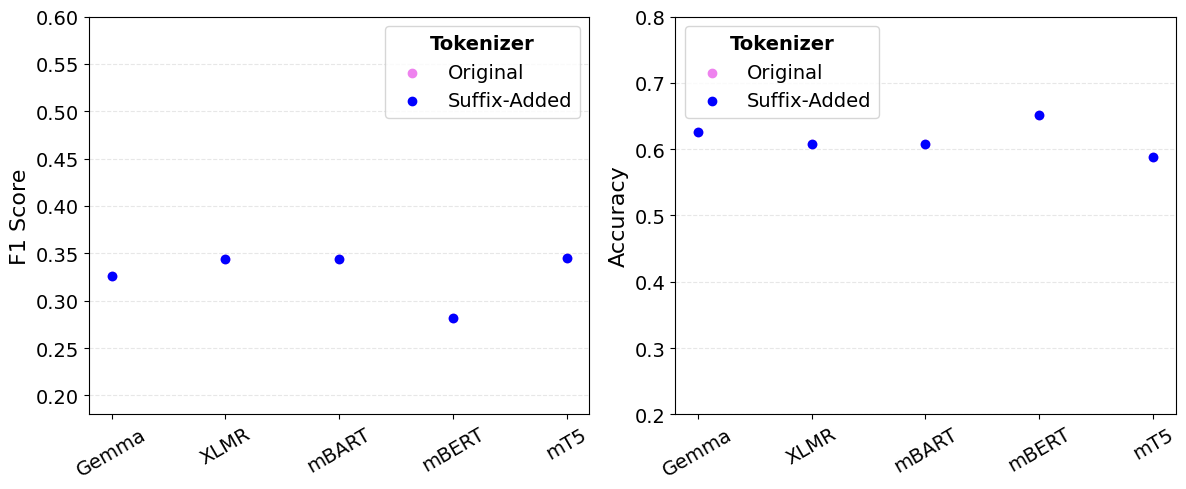

In [47]:
x = np.arange(len(labels))
width = 0.65

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True)
lower_f1 = np.minimum(orig_f1, added_f1)
upper_f1 = np.maximum(orig_f1, added_f1)

for xi, l, u, o, a in zip(x, lower_f1, upper_f1, orig_f1, added_f1):
    color = 'green' if a >= o else 'red'
    axes[0].vlines(xi, l, u, color=color, linewidth=6)
axes[0].scatter(x, orig_f1, color='violet', label='Original', zorder=5)
axes[0].scatter(x, added_f1, color='blue', label='Suffix-Added', zorder=5)
axes[0].set_ylabel('F1 Score', fontsize=16)
axes[0].legend(title='Tokenizer', 
          title_fontproperties={'weight': 'bold', 'size': 14},
          fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
axes[0].set_ylim(0.18, 0.6)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=30, fontsize=14)

# --- Accuracy Candle Plot ---
lower_acc = np.minimum(orig_acc, added_acc)
upper_acc = np.maximum(orig_acc, added_acc)

for xi, l, u, o, a in zip(x, lower_acc, upper_acc, orig_acc, added_acc):
    color = 'green' if a >= o else 'red'
    axes[1].vlines(xi, l, u, color=color, linewidth=6)
axes[1].scatter(x, orig_acc, color='violet', label='Original', zorder=2)
axes[1].scatter(x, added_acc, color='blue', label='Suffix-Added', zorder=2)
axes[1].set_ylabel('Accuracy', fontsize=16)
axes[1].legend(title='Tokenizer', 
          title_fontproperties={'weight': 'bold', 'size': 14},
          fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
axes[1].set_ylim(0.2, 0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=30, fontsize=14)
axes[1].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig("f1_accuracy_candle_comparison.png", dpi=300)
plt.show()


## Influence of Vocabulary

In [31]:
Unique_3k_df, bbpe3, unigram3, wordpiece3 = custom_tokenize_dataset(unique_df, "Unique_3k.txt", "3k", 'Words',"IndicCorpus",False)
Unique_5k_df, bbpe5, unigram5, wordpiece5 = custom_tokenize_dataset(unique_df, "Unique_5k.txt", "5k", 'Words', "IndicCorpus",False)
Unique_8k_df, bbpe8, unigram8, wordpiece8 = custom_tokenize_dataset(unique_df, "Unique_8k.txt", "8k", 'Words',"IndicCorpus",False)
Unique_10k_df, bbpe10, unigram10, wordpiece10 = custom_tokenize_dataset(unique_df, "Unique_10k.txt", "10k", 'Words', "IndicCorpus",False)
Unique_20k_df, bbpe20, unigram20, wordpiece20 = custom_tokenize_dataset(unique_df, "Unique_20k.txt", "20k", 'Words', "IndicCorpus",False)
Unique_32k_df, bbpe32, unigram32, wordpiece32 = custom_tokenize_dataset(unique_df, "Unique_32k.txt", "32k", 'Words', "IndicCorpus",False, True)

tokenizers = ["Byte-level BPE", "Unigram", "Wordpiece"]
vocab_sizes = ["3k", "5k", "8k", "10k", "20k", "32k"]
total = Unique_3k_df.shape[0]
y = np.array([
    [Unique_3k_df['Token Length BBPE'].sum()/total, Unique_5k_df['Token Length BBPE'].sum() / total, Unique_8k_df['Token Length BBPE'].sum() / total, 
         Unique_10k_df['Token Length BBPE'].sum()/total, Unique_20k_df['Token Length BBPE'].sum() / total, Unique_32k_df['Token Length BBPE'].sum() / total],
    [Unique_3k_df['Token Length Unigram'].sum()/total, Unique_5k_df['Token Length Unigram'].sum() / total, Unique_8k_df['Token Length Unigram'].sum() / total,
        Unique_10k_df['Token Length Unigram'].sum()/total, Unique_20k_df['Token Length Unigram'].sum() / total, Unique_32k_df['Token Length Unigram'].sum() / total],
    [Unique_3k_df['Token Length WordPiece'].sum()/total, Unique_5k_df['Token Length WordPiece'].sum() / total, Unique_8k_df['Token Length WordPiece'].sum() / total,
        Unique_10k_df['Token Length WordPiece'].sum()/total, Unique_20k_df['Token Length WordPiece'].sum() / total, Unique_32k_df['Token Length WordPiece'].sum() / total]
])

In [32]:
data = {
    "3K": [0.575410, 0.666544, 0.599857],
    "5K": [0.650669, 0.703954, 0.647859],
    "8K": [0.692551, 0.731690, 0.698308],
    "10K": [0.707972, 0.744014, 0.717327],
    "20K": [0.770897, 0.776606, 0.766696],
    "32K": [0.794777, 0.794510, 0.784434]
}

tokenizers = ["Byte-level BPE", "UnigramLM", "Wordpiece"]

Indic_df = pd.DataFrame(data, index=tokenizers)
Indic_df.head()

,3K,5K,8K,10K,20K,32K
Byte-level BPE,0.575410,0.650669,0.692551,0.707972,0.770897,0.794777
UnigramLM,0.666544,0.703954,0.731690,0.744014,0.776606,0.794510
Wordpiece,0.599857,0.647859,0.698308,0.717327,0.766696,0.784434


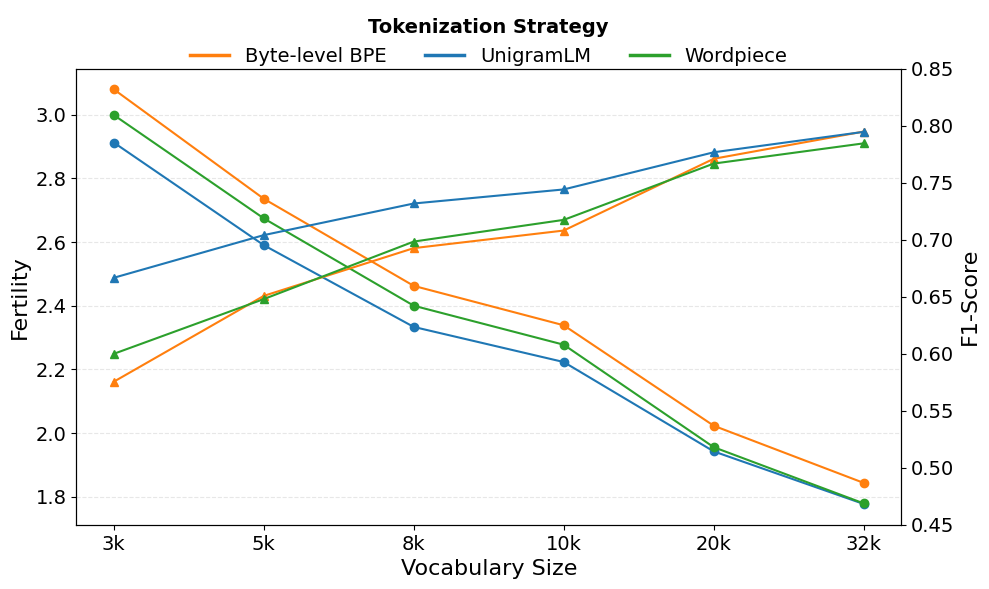

In [33]:
fig, ax1 = plt.subplots(figsize=(10,6))
x = np.arange(len(vocab_sizes))

colors = {
    "Byte-level BPE": "#ff7f0e",
    "UnigramLM": "#1f77b4",
    "Wordpiece": "#2ca02c"
}
for i, tokenizer in enumerate(tokenizers):
    ax1.plot(x, y[i, :], marker='o', color=colors[tokenizer], linewidth=1.5, label=tokenizer)
ax1.set_xticks(x)
ax1.set_xticklabels(vocab_sizes, fontsize=14)
ax1.set_xlabel("Vocabulary Size", fontsize=16)
ax1.set_ylabel("Fertility", fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(axis='y', alpha=0.3, linestyle='--')


ax2 = ax1.twinx()
for i, tokenizer in enumerate(tokenizers):
    ax2.plot(x, Indic_df.loc[tokenizer], marker='^', color=colors[tokenizer], linewidth=1.5)
ax2.set_ylabel("F1-Score", fontsize=16)
ax2.set_ylim(0.45, 0.85)
ax2.tick_params(axis='y', labelsize=14)

legend_elements = [Line2D([0], [0], color=colors[tok], lw=2.5, label=tok) for tok in tokenizers]
ax1.legend(
    handles=legend_elements,
    title='Tokenization Strategy',
    title_fontproperties={'weight': 'bold', 'size': 14},
    fontsize=14,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    frameon=False
)
plt.tight_layout()
plt.savefig('Fertility_F1_Vocab.jpg', dpi=1000, bbox_inches='tight')
plt.show()
